## Script to create CRC STR and Splice Event pairs that occur within the same gene. The correlation between the CRC STR mean length and the Splice Event PSI for tumor samples will be calculated

## Analysis for SplAdder data


In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf


warnings.filterwarnings('ignore')

In [2]:
crc_samples_meta_data = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/CRC_msi.csv")
patients_in_metadata = crc_samples_meta_data['patient'].to_list()

In [97]:
def create_str_pivot(coad_data, read_data, str_meta_data):

    # Read STR data
    df_coad = pd.read_csv(coad_data)
    df_read = pd.read_csv(read_data)
    # Read STR anotation
    df_str_annotated = pd.read_csv(str_meta_data, sep='\t')
    df_str_annotated = df_str_annotated[['tmp_id', 'gene_names', 'gene_ensembl_ids']]

    # Combine COAD and READ STR
    df = df_read.append(df_coad)
    # Calculate STR mean length
    df['mean_length'] = (df['allele_a'] + df['allele_b']) / 2


    # Create STR pivot table -> for each STR and tumor sample the table contains the STR mean length
    pivot_df = pd.pivot_table(df, 
                            index='tmp_id', 
                            columns='sample', 
                            values=['mean_length'], 
                            aggfunc='mean',
                            fill_value=0)

    # Set column names
    pivot_df.columns = [col[1] for col in pivot_df.columns]
    pivot_df_copy = pivot_df.copy()
    # Cut column names 
    pivot_df_copy.columns = ['-'.join(col.split('-')[:3]) for col in pivot_df_copy.columns]
    # Remove STR with same length over all tumor samples
    pivot_df = pivot_df_copy.drop_duplicates(keep=False)
    # Count zero values for each row
    #zero_counts = pivot_df.eq(0).sum(axis=1)
    # Count non-zero values for each row
    #non_zero_counts = pivot_df.ne(0).sum(axis=1)
    # Filter rows where the number of zeros is less than or equal to the number of non-zero values
    #pivot_df = pivot_df[(zero_counts <= non_zero_counts)]

    # Indices to column
    pivot_df.reset_index(inplace=True)
    # Replace "_" by "-" in column names
    pivot_df.rename(columns=lambda x: x.replace('_', '-'), inplace=True)
    # Rename 'tmp-id' column
    pivot_df.rename(columns={'tmp-id': 'tmp_id'}, inplace=True)
    # Merge pivor_ df annotation file -> create annotated CRC STRs
    pivot_annotated = pd.merge(pivot_df, df_str_annotated, on='tmp_id', how='inner')
    # Relocate columns
    cols = list(pivot_annotated.columns)
    cols.insert(1, cols.pop(cols.index('gene_names')))
    cols.insert(2, cols.pop(cols.index('gene_ensembl_ids')))
    pivot_annotated = pivot_annotated[cols]
    # Remove duplicated columns
    pivot_annotated = pivot_annotated.loc[:, ~pivot_annotated.columns.duplicated()]
    return pivot_annotated

pivot_annotated = create_str_pivot("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/COAD_pt.csv", 
                                  "/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/READ_pt.csv", 
                                  "/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/tral_and_perf_panel_meta_info_updated.tsv")

'''

def process_str_ase(ase_data, pivot_annotated):
    #Import Splicing Event dataset
    df_SplAdder = pd.read_csv(ase_data, sep='\t')
    # Remove duplicated rows
    df_SplAdder = df_SplAdder.drop_duplicates()

    # Split ASE tumor samples names -> create same name structure like STR (to compare STR and ASE samples)
    cols_to_modify = df_SplAdder.columns[15:]
    df_SplAdder.rename(columns={col: '-'.join(col.split('-')[:3]) for col in cols_to_modify}, inplace=True)
    # Remove duplicated columns
    df_SplAdder = df_SplAdder.loc[:, ~df_SplAdder.columns.duplicated()]
    # Columns of STR data
    cols_str_spladder = pivot_annotated.columns[1:].tolist() # pivot_annotated
    # Columns of ASE data
    cols_ase_spladder = df_SplAdder.columns[15:].tolist()
    patients_in_metadata_and_spladder = list(set(cols_ase_spladder).intersection(set(patients_in_metadata)))
    
    
    # Get tumor samples that are in STR and ASE data
    cols_str_ase_spladder = set(patients_in_metadata_and_spladder).intersection(cols_str_spladder) # 370
    # Convert set 'cols_str_ase' to list
    cols_str_ase_spladder = list(cols_str_ase_spladder)
    # Create STR with tumor samples and the first 3 columns of the original columns ("tmp_id","gene_names","gene_ensembl_ids")
    pivot_annotated = pivot_annotated[list(pivot_annotated.columns[:3]) + cols_str_ase_spladder]
    # Create ASE with tumor samples and the first 15 columns
    df_SplAdder = df_SplAdder[list(df_SplAdder.columns[:15]) + cols_str_ase_spladder]
    # Rename column 'GeneSymbol' in ASE data
    df_SplAdder.rename(columns={'GeneSymbol': 'gene_names'}, inplace=True)
    # count zero-values for each rows
    ase_zero_counts = df_SplAdder.iloc[:, 15:].apply(lambda row: row.isin([0, np.nan]).sum(), axis=1)
    # count non zero-values for each rows
    ase_non_zero_counts = (df_SplAdder.iloc[:, 15:] != 0).sum(axis=1) & df_SplAdder.iloc[:, 15:].notna().sum(axis=1)
    # Filter rows where the number of zeros is less than or equal 
    df_SplAdder = df_SplAdder[(ase_zero_counts >= ase_non_zero_counts)]
    return df_SplAdder, pivot_annotated, cols_str_ase_spladder

df_SplAdder, pivot_annotated, cols_str_ase_spladder =  process_str_ase("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/Spladder_PSI_COAD_and_READ.tsv",
                                               pivot_annotated)


#pivot_annotated.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/CRC_STR_new.csv")

def merge_str_ase(df_SplAdder, pivot_annotated):
    # Merge annotated CRC STR and SplAdder ASE -> create pairs of ASE and STR that occur in the same gene
    str_ase = pd.merge(pivot_annotated, df_SplAdder, on='gene_names', how='inner')
    # Delete duplicated based on the column tmp_id', 'gene_ensembl_ids'
    str_ase = str_ase.drop_duplicates(subset=['tmp_id', 'SpliceEvent'])
    return str_ase

spladder_str_ase = merge_str_ase(df_SplAdder, pivot_annotated)

def calculare_correlation(str_ase):
    # Create data frame of STR and ASE pairs 
    str_ase_pairs = str_ase[['tmp_id','SpliceEvent', 'gene_names', 'GeneID']]

    # Create empty data frame 
    df_str_ase = pd.DataFrame(columns=['crc_str', 'splice_event', 'gene_name', 'pearson_coefficient', 'p_value'])

    # Iterate over len of STR-ASE pairs 
    print(len(str_ase_pairs))
    for i in range(len(str_ase_pairs)):
        # Select STR
        crc_str = pivot_annotated[pivot_annotated['tmp_id'] == str_ase_pairs['tmp_id'].iloc[i]].iloc[:,3:].iloc[0].tolist()
        # Select ASE
        ase = df_SplAdder[df_SplAdder['SpliceEvent'] == str_ase_pairs['SpliceEvent'].iloc[i]].iloc[:, 15:].iloc[0].tolist()
        # Select gene name
        gene_name = df_SplAdder[df_SplAdder['gene_names'] == str_ase_pairs['gene_names'].iloc[i]].iloc[:, 15:].iloc[0].tolist()
        # Select Gene ID for Splice Event
        gene_id = df_SplAdder[df_SplAdder['GeneID'] == str_ase_pairs['GeneID'].iloc[i]].iloc[:, 15:].iloc[0].tolist()
        # Create data frame of the selected STR and ASE
        data = {'crc_str': crc_str,'ase': ase}
        # Create a DataFrame
        df = pd.DataFrame(data)
        # Fill 'NaN' values with 0
        df = df.fillna(0)
        # Calculate pearson_coefficient and p_value for each STR-ASE pair
        correlation_coefficient, p_value = pearsonr(df['crc_str'], df['ase'])
        # Fill data frame
        str_ase = {'crc_str': str_ase_pairs['tmp_id'].iloc[i], 
                    'splice_event': str_ase_pairs['SpliceEvent'].iloc[i],
                    'gene_name': str_ase_pairs['gene_names'].iloc[i],
                    'gene_id': str_ase_pairs['GeneID'].iloc[i],
                    'pearson_coefficient': correlation_coefficient,
                    'p_value': p_value}
        df_str_ase = df_str_ase.append(str_ase, ignore_index=True)
        if i % 1000 == 0:
            print(i)
    # Sort data frame by 'pearson_coefficient'
    df_str_ase = df_str_ase.sort_values(by='pearson_coefficient', ascending=False)
    
    return df_str_ase

df_str_ase_spladder = calculare_correlation(spladder_str_ase)
df_str_ase_spladder = df_str_ase_spladder[['crc_str', 'splice_event', 'gene_name', 'gene_id' ,'pearson_coefficient', 'p_value']]
'''


'\n\ndef process_str_ase(ase_data, pivot_annotated):\n    #Import Splicing Event dataset\n    df_SplAdder = pd.read_csv(ase_data, sep=\'\t\')\n    # Remove duplicated rows\n    df_SplAdder = df_SplAdder.drop_duplicates()\n\n    # Split ASE tumor samples names -> create same name structure like STR (to compare STR and ASE samples)\n    cols_to_modify = df_SplAdder.columns[15:]\n    df_SplAdder.rename(columns={col: \'-\'.join(col.split(\'-\')[:3]) for col in cols_to_modify}, inplace=True)\n    # Remove duplicated columns\n    df_SplAdder = df_SplAdder.loc[:, ~df_SplAdder.columns.duplicated()]\n    # Columns of STR data\n    cols_str_spladder = pivot_annotated.columns[1:].tolist() # pivot_annotated\n    # Columns of ASE data\n    cols_ase_spladder = df_SplAdder.columns[15:].tolist()\n    patients_in_metadata_and_spladder = list(set(cols_ase_spladder).intersection(set(patients_in_metadata)))\n    \n    \n    # Get tumor samples that are in STR and ASE data\n    cols_str_ase_spladder = set(

In [8]:
import ensembl_rest
def get_gene_info(gene_name_list, info):
    gene_functions = {}
    try:
        for gene in gene_name_list:
            gene_function = ensembl_rest.symbol_lookup(

                    species='homo sapiens',

                    symbol=gene

            )
            gene_functions[gene] = gene_function[info]
    except:
        gene_functions[gene] = None
    return gene_functions    

In [38]:
mask = (df_str_ase_spladder['p_value'] >= 0) & (df_str_ase_spladder['p_value'] <= 1)
df_str_ase_spladder = df_str_ase_spladder[mask]
df_str_ase_spladder['adjusted_p_value'] = stats.false_discovery_control(df_str_ase_spladder['p_value'])

mask = ~df_str_ase_spladder['crc_str'].str.contains('chrX|chrY')

# Filter DataFrame using the mask
df_str_ase_spladder = df_str_ase_spladder[mask]

df_str_ase_spladder_filtered = df_str_ase_spladder[(df_str_ase_spladder['adjusted_p_value'] < 0.05) & ((df_str_ase_spladder['pearson_coefficient'] > 0.2) | (df_str_ase_spladder['pearson_coefficient'] < -0.2))]

gene_fuction = get_gene_info(df_str_ase_spladder_filtered['gene_name'], 'description')
df_str_ase_spladder_filtered['gene_function'] = df_str_ase_spladder_filtered['gene_name'].map(gene_fuction)
df_str_ase_spladder_filtered['gene_id'] = df_str_ase_spladder_filtered['gene_id'].str.split('.').str[0]
df_str_ase_spladder['str_ase_pairs'] = df_str_ase_spladder['crc_str']+ '; id:' +df_str_ase_spladder['splice_event'] 

genes_counts = df_str_ase_spladder_filtered['gene_name'].value_counts()
genes_counts

PRKCSH    57
ACTN4     50
TCF3      44
MYH14     38
MYH11     36
          ..
PSAP       1
MYOM3      1
PSRC1      1
DHX8       1
PKIB       1
Name: gene_name, Length: 1105, dtype: int64

In [23]:
df_str_ase_spladder_filtered.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SplAdder_STR_ASE_pairs_correlation.csv")

In [11]:
df_str_ase_spladder.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SplAdder_STR_ASE_pairs_correlation.csv")

### Nur falls die vorherige Analyse (siehe oben) nicht nochmal durchgeführt werden soll

In [151]:
df_str_ase_spladder = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SplAdder_STR_ASE_pairs_correlation.csv")
df_str_ase_spladder_filtered = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SplAdder_STR_ASE_pairs_correlation.csv")

### P-value Plot

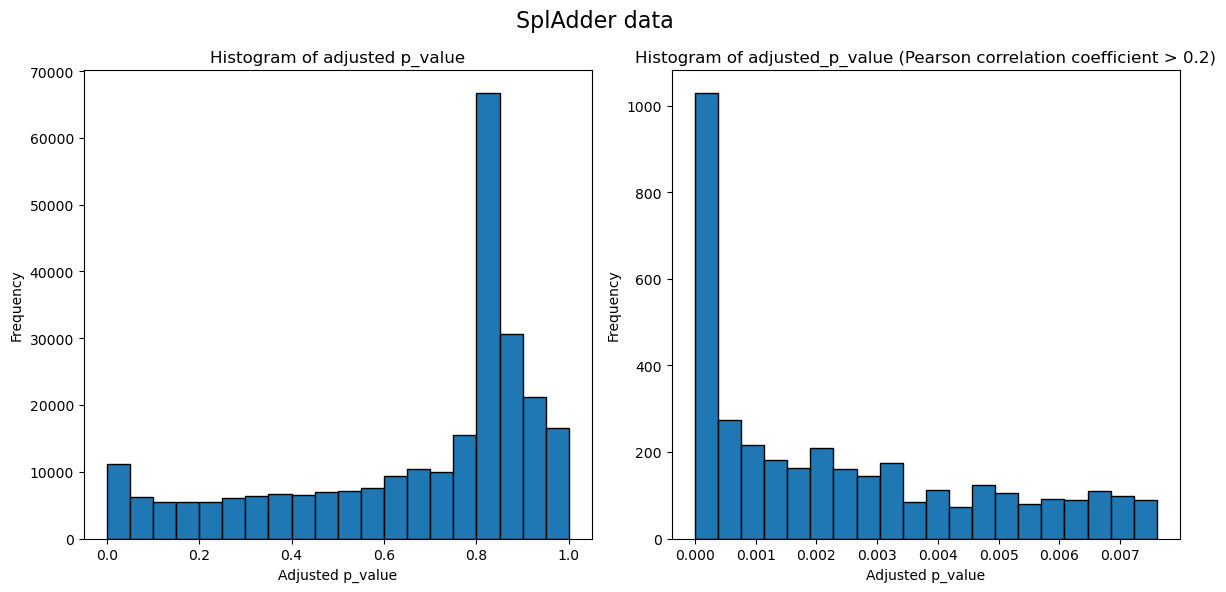

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the first histogram
axes[0].hist(df_str_ase_spladder['adjusted_p_value'], bins=20, edgecolor='black')
axes[0].set_xlabel('Adjusted p_value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of adjusted p_value')

# Plot the second histogram
axes[1].hist(df_str_ase_spladder_filtered['adjusted_p_value'], bins=20, edgecolor='black')
axes[1].set_xlabel('Adjusted p_value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of adjusted_p_value (Pearson correlation coefficient > 0.2)')

fig.suptitle('SplAdder data', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

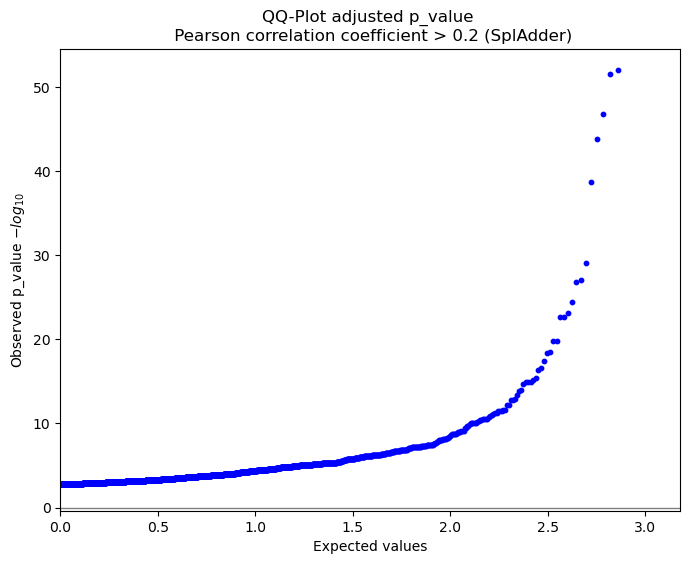

In [82]:
# Transformation der p-Werte in -log10(p-Werte)
neg_log10_p_values = -np.log10(df_str_ase_spladder_filtered['adjusted_p_value'])

# QQ-Plot-Daten ohne Linie erstellen
res = stats.probplot(neg_log10_p_values, dist="norm")

# Manuell plotten
plt.figure(figsize=(8, 6))
plt.scatter(res[0][0], res[0][1], color='blue', s=10)
plt.title("QQ-Plot adjusted p_value \n Pearson correlation coefficient > 0.2 (SplAdder)")
plt.xlabel("Expected values")
plt.ylabel("Observed p_value $-log_{10}$")
plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)
plt.xlim(left=0)
plt.show()

### Vulcano Plot

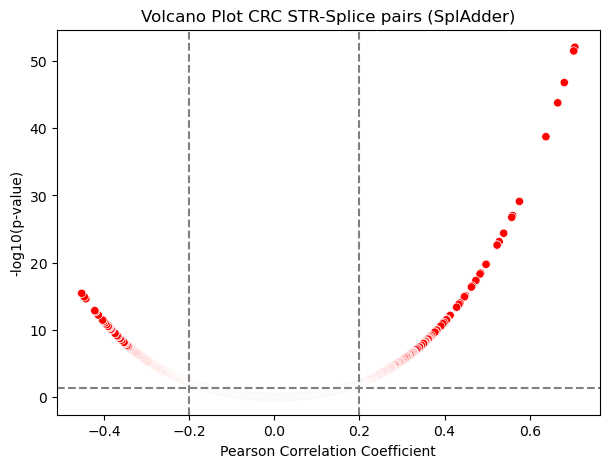

In [57]:
import matplotlib.pyplot as plt
data_spladder = df_str_ase_spladder[['adjusted_p_value', 'pearson_coefficient']]
data_spladder['-log10(p_value)'] = -np.log10(data_spladder['adjusted_p_value'])

plt.figure(figsize=(7, 5))

# Define significance thresholds
correlation_threshold = 0.2
p_value_threshold = 0.05

sns.scatterplot(
 data=data_spladder, 
    x='pearson_coefficient', 
    y='-log10(p_value)',
    hue=(data_spladder['adjusted_p_value'] < p_value_threshold) & (abs(data_spladder['pearson_coefficient']) > correlation_threshold),
    palette={True: 'red', False: 'black'},
    legend=False
)

plt.axhline(y=-np.log10(p_value_threshold), color='grey', linestyle='--')
plt.axvline(x=correlation_threshold, color='grey', linestyle='--')
plt.axvline(x=-correlation_threshold, color='grey', linestyle='--')

plt.title('Volcano Plot CRC STR-Splice pairs (SplAdder)')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('-log10(p-value)')

plt.show()

### Count number of negative and positive correlations

In [58]:
# Count number of positive correlations
positive_count_spladder = (df_str_ase_spladder_filtered['pearson_coefficient'] > 0).sum()

# Count number of negative correlations
negative_count_spladder = (df_str_ase_spladder_filtered['pearson_coefficient'] < 0).sum()
print(positive_count_spladder, negative_count_spladder)


913 2698


## Analysis for SpliceSeq data

In [3]:
df_coad = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/COAD_pt.csv")
df_read = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/READ_pt.csv")
# Read STR anotation
df_str_annotated = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/tral_and_perf_panel_meta_info_updated.tsv", sep='\t')
df_str_annotated = df_str_annotated[['tmp_id', 'gene_names', 'gene_ensembl_ids']]

# Combine COAD and READ STR
df = df_read.append(df_coad)
    # Calculate STR mean length
df['mean_length'] = (df['allele_a'] + df['allele_b']) / 2


# Create STR pivot table -> for each STR and tumor sample the table contains the STR mean length
pivot_df = pd.pivot_table(df, 
                          index='tmp_id', 
                          columns='sample', 
                          values=['mean_length'], 
                          aggfunc='mean',
                          fill_value=0)

# Set columns name
pivot_df.columns = [col[1] for col in pivot_df.columns]
pivot_df_copy = pivot_df.copy()
# Cut column names 
pivot_df_copy.columns = ['-'.join(col.split('-')[:3]) for col in pivot_df_copy.columns]
# Remove STR with same length over all tumor samples
pivot_df = pivot_df_copy.drop_duplicates(keep=False)
# Count zero values for each row
zero_counts = pivot_df.eq(0).sum(axis=1)
# Count non-zero values for each row
non_zero_counts = pivot_df.ne(0).sum(axis=1)
# Filter rows where the number of zeros is less than or equal to the number of non-zero values
pivot_df = pivot_df[(zero_counts <= non_zero_counts)]
    
pivot_df.reset_index(inplace=True)
# Replace "_" by "-" in column names
pivot_df.rename(columns=lambda x: x.replace('_', '-'), inplace=True)
# Rename 'tmp-id' column
pivot_df.rename(columns={'tmp-id': 'tmp_id'}, inplace=True)
# Merge pivor_ df annotation file -> create annotated CRC STRs
pivot_annotated = pd.merge(pivot_df, df_str_annotated, on='tmp_id', how='inner')
# Relocate columns
cols = list(pivot_annotated.columns)
cols.insert(1, cols.pop(cols.index('gene_names')))
cols.insert(2, cols.pop(cols.index('gene_ensembl_ids')))
pivot_annotated = pivot_annotated[cols]
# Remove duplicated columns
pivot_annotated = pivot_annotated.loc[:, ~pivot_annotated.columns.duplicated()]


df_SpliceSeq_coad = pd.read_csv("/Users/aychaserradj/Downloads/PSI_download_COAD.txt", sep='\t')
df_SpliceSeq_read = pd.read_csv("/Users/aychaserradj/Downloads/PSI_download_READ.txt", sep='\t')

df_SpliceSeq_coad['cancer_type'] = 'coad'
df_SpliceSeq_read['cancer_type'] = 'read'

df_SpliceSeq = pd.concat([df_SpliceSeq_coad, df_SpliceSeq_read], ignore_index=True)


df_SpliceSeq.columns = df_SpliceSeq.columns.str.replace('_', '-')
column_to_move = df_SpliceSeq.pop('cancer-type')
df_SpliceSeq.insert(10, 'cancer-type', column_to_move)
cols = df_SpliceSeq.columns[11:]


df_SpliceSeq = df_SpliceSeq.loc[:, ~df_SpliceSeq.columns.duplicated()]
cols_str_spliceseq = pivot_annotated.columns[1:].tolist()

patients_in_metadata_and_spladder = list(set(cols_str_spliceseq).intersection(set(patients_in_metadata)))

# Get tumor samples that are in STR and ASE data
cols_str_ase_spliceseq = set(cols).intersection(patients_in_metadata_and_spladder) # 577 patients 
# Convert set 'cols_str_ase' to list
cols_str_ase_spliceseq = list(cols_str_ase_spliceseq)

pivot_annotated = pivot_annotated[list(pivot_annotated.columns[:3]) + cols_str_ase_spliceseq]
df_SpliceSeq = df_SpliceSeq[list(df_SpliceSeq.columns[:11]) + cols_str_ase_spliceseq]

df_SpliceSeq.rename(columns={'symbol': 'gene_names'}, inplace=True)

str_ase = pd.merge(pivot_annotated, df_SpliceSeq, on='gene_names', how='inner')
str_ase = str_ase.drop_duplicates(subset=['tmp_id', 'gene_names', 'cancer-type'])
str_ase

str_ase_pairs = str_ase[['tmp_id','gene_names', 'as-id', 'cancer-type']]
str_ase_pairs

df_str_ase = pd.DataFrame(columns=['crc_str', 'as_id', 'gene_names', 'cancer_type', 'pearson_coefficient', 'p_value'])
regression_results = pd.DataFrame(columns=['gene_name', 'cancer_typ', 'crc_str', 'as_id', 'r_squared', 'adj_r_squared', 'f_pvalue', 'durbin_watson', 'pvalues_str_len', 'pvalues_race' ])

for i in range(len(str_ase_pairs)):

        crc_str = pivot_annotated[pivot_annotated['tmp_id'] == str_ase_pairs['tmp_id'].iloc[i]].iloc[:,3:].iloc[0].tolist()
        # Create data frame of the selected STR and ASE
        filtered_df = df_SpliceSeq[
            (df_SpliceSeq['as-id'] == str_ase_pairs['as-id'].iloc[i]) &
            (df_SpliceSeq['gene_names'] == str_ase_pairs['gene_names'].iloc[i]) &
            (df_SpliceSeq['cancer-type'] == str_ase_pairs['cancer-type'].iloc[i])
        ]
        # Select the columns starting from the 11th column onward and convert to list
        ase = filtered_df.iloc[:, 11:].iloc[0].tolist()
        data = {'crc_str': crc_str,'ase': ase, }
        df = pd.DataFrame(data)
        # Fill 'NaN' values with 0
        df = df.fillna(0)
        print(df)
        # Calculate pearson_coefficient and p_value for each STR-ASE pair
        correlation_coefficient, p_value = pearsonr(df['crc_str'], df['ase'])
        
        '''
        model = smf.ols('psi ~ str_len', data=test_df).fit()
    
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        f_pvalue = model.f_pvalue
        pvalues = model.pvalues
        durbin_watson = sm.stats.stattools.durbin_watson(model.resid)

        #print(r_squared, adj_r_squared, f_pvalue, pvalues, durbin_watson)

        regression_results.append({
        'gene_name': df_SpliceSeq['gene_names'].iloc[i],
        'cancer_typ': df_SpliceSeq['cancer-type'].iloc[i],
        'crc_str': pivot_annotated['tmp_id'].iloc[i], 
        'as_id': str_ase_pairs['as-id'].iloc[i],
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_pvalue': f_pvalue,
        'durbin_watson': durbin_watson,
        'pvalues_str_len': pvalues['str_len'],
        'pvalues_race': pvalues.filter(like='C(race)').to_dict()
        }, ignore_index =True)
        # Fill data frame
        str_ase = {'crc_str': str_ase_pairs['tmp_id'].iloc[i], 
                    'as_id': str_ase_pairs['as-id'].iloc[i],
                    'gene_names': str_ase_pairs['gene_names'].iloc[i],
                    'cancer_type': str_ase_pairs['cancer-type'].iloc[i],
                    'pearson_coefficient': correlation_coefficient,
                    'p_value': p_value}
        '''            
        df_str_ase = df_str_ase.append(str_ase, ignore_index=True)
    # Sort data frame by 'pearson_coefficient'
df_str_ase = df_str_ase.sort_values(by='pearson_coefficient', ascending=False)

df_str_ase = df_str_ase.dropna(subset=['pearson_coefficient'])
df_str_ase['adjusted_p_value'] = stats.false_discovery_control(df_str_ase['p_value'])

df_str_ase.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SpliceSeq_STR_ASE_pairs_correlation.csv")


df_str_ase_spliceseq_filtered = df_str_ase[(df_str_ase['adjusted_p_value'] < 0.05) & ((df_str_ase['pearson_coefficient'] > 0.2) | (df_str_ase['pearson_coefficient'] < -0.2))]
df_str_ase_spliceseq_filtered.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SpliceSeq_STR_ASE_pairs_correlation.csv")


     crc_str     ase
0          4  0.0000
1          4  0.9937
2          4  1.0000
3          4  1.0000
4          4  0.9814
..       ...     ...
572        4  0.0000
573        4  0.9829
574        4  0.0000
575        4  1.0000
576        4  1.0000

[577 rows x 2 columns]
     crc_str     ase
0          4  1.0000
1          4  0.0000
2          4  0.0000
3          4  0.0000
4          4  0.0000
..       ...     ...
572        4  0.9958
573        4  0.0000
574        4  1.0000
575        4  0.0000
576        4  0.0000

[577 rows x 2 columns]
     crc_str     ase
0          0  0.0000
1          0  0.9937
2          4  1.0000
3          0  1.0000
4          4  0.9814
..       ...     ...
572        4  0.0000
573        4  0.9829
574        4  0.0000
575        4  1.0000
576        4  1.0000

[577 rows x 2 columns]
     crc_str     ase
0          0  1.0000
1          0  0.0000
2          4  0.0000
3          0  0.0000
4          4  0.0000
..       ...     ...
572        4  0.9958
573 

: 

In [111]:
gene_fuction = get_gene_info(df_str_ase_spliceseq_filtered['gene_names'], 'description')
df_str_ase_spliceseq_filtered['gene_function'] = df_str_ase_spliceseq_filtered['gene_names'].map(gene_fuction)

#df_str_ase_spliceseq_filtered.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SpliceSeq_STR_ASE_pairs_correlation.csv")

df_str_ase['str_ase_pairs'] = df_str_ase['crc_str']+ '; id:' +df_str_ase['as_id'].astype(str) + ';'+ df_str_ase['cancer_type']
df_str_ase.columns

#gene_symbol = get_gene_info(df_str_ase_spliceseq_filtered['gene_names'], 'id')
#df_str_ase_spliceseq_filtered['gene_id'] = df_str_ase_spliceseq_filtered['gene_names'].map(gene_symbol)
#df_str_ase_spliceseq_filtered = df_str_ase_spliceseq_filtered.reset_index()

df_str_ase_spliceseq_filtered

,crc_str,as_id,gene_names,cancer_type,pearson_coefficient,p_value,adjusted_p_value,gene_function
10770,chr19_1808230,46543,ATP8B3,coad,0.470718,3.726097e-33,1.126958e-28,ATPase phospholipid transporting 8B3 [Source:H...
11195,chr19_43848665,50245,ZNF283,coad,0.465229,2.498228e-32,3.777945e-28,zinc finger protein 283 [Source:HGNC Symbol;Ac...
12743,chr1_19149719,872,UBR4,coad,0.456423,4.926286e-31,4.966517e-27,ubiquitin protein ligase E3 component n-recogn...
28221,chr9_110579107,87186,SVEP1,coad,0.447523,9.190748e-30,6.949355e-26,"sushi, von Willebrand factor type A, EGF and p..."
10007,chr17_80425579,44050,ENDOV,coad,0.446622,1.229871e-29,7.439491e-26,endonuclease V [Source:HGNC Symbol;Acc:HGNC:26...
...,...,...,...,...,...,...,...,...
30254,chrX_47223664,88910,CDK16,read,-0.289713,1.276720e-12,3.139382e-10,NaN
15475,chr21_25639852,60253,JAM2,read,-0.298901,2.257723e-13,7.264344e-11,NaN
15709,chr21_45456185,60874,COL18A1,read,-0.309502,2.828958e-14,1.056319e-11,NaN
10577,chr19_1123585,46390,SBNO2,read,-0.327140,7.379950e-16,3.600106e-13,NaN


In [122]:
#df_str_ase_spliceseq_filtered = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SpliceSeq_STR_ASE_pairs_correlation.csv")
#df_str_ase_spliceseq = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SpliceSeq_STR_ASE_pairs_correlation.csv")
#df_str_ase_spliceseq_filtered['adjusted_p_value']

0      1.126958e-28
1      3.777945e-28
2      4.966517e-27
3      6.949355e-26
4      7.439491e-26
           ...     
785    3.139382e-10
786    7.264344e-11
787    1.056319e-11
788    3.600106e-13
789    2.987646e-13
Name: adjusted_p_value, Length: 790, dtype: float64

### P-values Plot

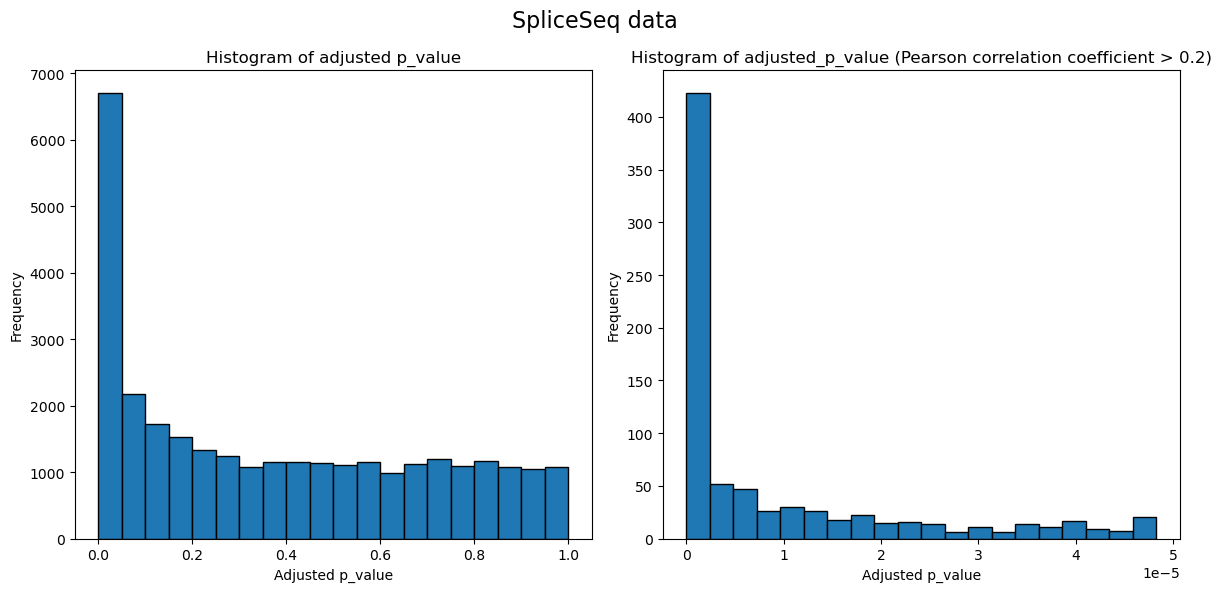

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the first histogram
axes[0].hist(df_str_ase['adjusted_p_value'], bins=20, edgecolor='black')
axes[0].set_xlabel('Adjusted p_value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of adjusted p_value')

# Plot the second histogram
axes[1].hist(df_str_ase_spliceseq_filtered['adjusted_p_value'], bins=20, edgecolor='black')
axes[1].set_xlabel('Adjusted p_value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of adjusted_p_value (Pearson correlation coefficient > 0.2)')

fig.suptitle('SpliceSeq data', fontsize=16)
# Adjust layout
plt.tight_layout()
plt.show()

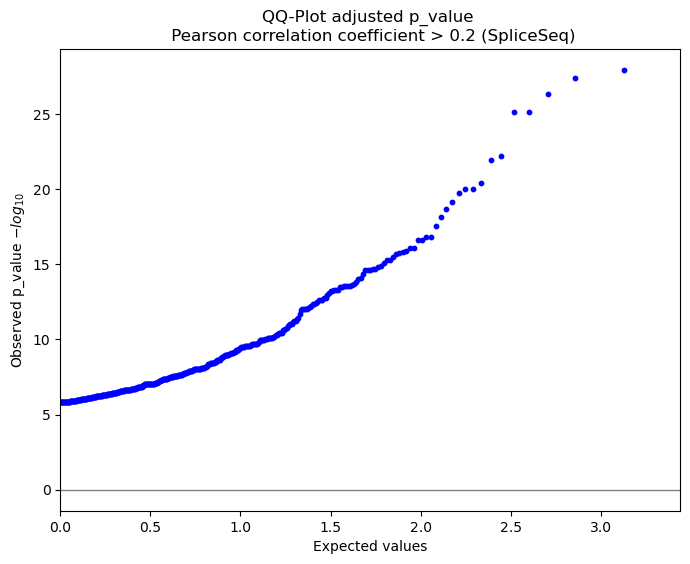

In [83]:
neg_log10_p_values_spliceseq = -np.log10(df_str_ase_spliceseq_filtered['adjusted_p_value'])

# QQ-Plot-Daten ohne Linie erstellen
res = stats.probplot(neg_log10_p_values_spliceseq, dist="norm")

# Manuell plotten
plt.figure(figsize=(8, 6))
plt.scatter(res[0][0], res[0][1], color='blue', s=10)
plt.title("QQ-Plot adjusted p_value \n Pearson correlation coefficient > 0.2 (SpliceSeq)")
plt.xlabel("Expected values")
plt.ylabel("Observed p_value $-log_{10}$")
plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)
plt.xlim(left=0)
plt.show()

### Vulcano Plot significant CRC STR-ASE pairs

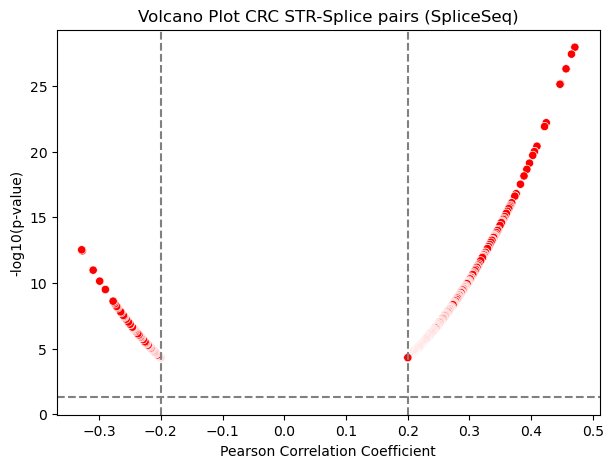

In [64]:
import matplotlib.pyplot as plt
data = df_str_ase_spliceseq_filtered[['adjusted_p_value', 'pearson_coefficient']]
data['-log10(p_value)'] = -np.log10(data['adjusted_p_value'])

plt.figure(figsize=(7, 5))

# Define significance thresholds
correlation_threshold = 0.2
p_value_threshold = 0.05

sns.scatterplot(
 data=data, 
    x='pearson_coefficient', 
    y='-log10(p_value)',
    hue=(data['adjusted_p_value'] < p_value_threshold) & (abs(data['pearson_coefficient']) > correlation_threshold),
    palette={True: 'red', False: 'black'},
    legend=False
)

plt.axhline(y=-np.log10(p_value_threshold), color='grey', linestyle='--')
plt.axvline(x=correlation_threshold, color='grey', linestyle='--')
plt.axvline(x=-correlation_threshold, color='grey', linestyle='--')

plt.title('Volcano Plot CRC STR-Splice pairs (SpliceSeq)')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('-log10(p-value)')

plt.show()


### Count number of negative and positive correlations 

In [65]:
# Count number of positive correlations
positive_count_spliceseq = (df_str_ase_spliceseq_filtered['pearson_coefficient'] > 0).sum()
print(positive_count_spliceseq)

# Count number of negative correlations
negative_count_spliceseq = (df_str_ase_spliceseq_filtered['pearson_coefficient'] < 0).sum()
print(negative_count_spliceseq)


683
107


## Intesect genes Spladder and SpliceSeq 

In [181]:
genes_in_spladder_and_spliceseq =[item for item in df_str_ase_spladder_filtered['gene_name'].unique().tolist() if item in df_str_ase_spliceseq_filtered['gene_names'].unique().tolist()]
len(genes_in_spladder_and_spliceseq)

68

In [21]:
def get_gene_correlation(df, gene_list, gene_col_name):
    gene_correlation_dict = {}

    # Loop through the list of gene names and extract correlation values from the DataFrame
    for gene in gene_list:
        # Get the correlation values for the current gene
        correlation_values = df[df[gene_col_name] == gene]['pearson_coefficient'].tolist()
        # Add the gene and its correlation values to the dictionary
        gene_correlation_dict[gene] = correlation_values

    return gene_correlation_dict    

In [27]:
spladder_gene_correlation_dict = get_gene_correlation(df_str_ase_spladder_filtered,genes_in_spladder_and_spliceseq, 'gene_name')
spliceseq_gene_correlation_dict = get_gene_correlation(df_str_ase_spliceseq_filtered,genes_in_spladder_and_spliceseq, 'gene_names')

spladder_gene_correlation_dict

{'APOL1': [0.3947566467161936,
  0.3914425273184001,
  0.3888410011818813,
  0.3840278820221744,
  0.3826199758852698,
  0.3792100297610268,
  0.2724618402189488,
  0.2404816372359638,
  0.2114551037024273],
 'SH3BP1': [0.3524112267266856,
  0.3476927507306225,
  0.3129587631505999,
  0.2048399755719358],
 'SCAMP4': [0.3506355145119774,
  0.3409419757985,
  0.3339201930236425,
  0.3086581581319038],
 'KCNN4': [0.3321569661288323,
  0.3292024782981294,
  0.3239526819617468,
  0.3212670017117158,
  0.3209797017509266,
  0.320264948124937,
  0.2289317244365982,
  0.2046409568740366],
 'UACA': [0.3215413238351698,
  0.2639984883862754,
  0.2330195796560018,
  0.2158247016039304,
  0.2096570172476189],
 'GAK': [0.3212734771034649,
  0.3212642886460079,
  0.3195458712162257,
  0.3184255916019404,
  0.3182508531080064,
  0.3181520788979147,
  0.3178868680355474,
  0.3163270427005976,
  0.3155964409048872,
  0.3151092961001062,
  0.3150838167187901,
  0.3136639799675214,
  0.313232033988521,
 

In [28]:
spliceseq_gene_correlation_dict

{'APOL1': [0.2680366447755685, -0.2715025371011849],
 'SH3BP1': [0.2363262087215313, -0.2708401049337998],
 'SCAMP4': [0.3312949887376209,
  0.2529588865543111,
  -0.2524316782338057,
  -0.3280871965553095],
 'KCNN4': [0.2748505690457678, -0.276128599106138],
 'UACA': [-0.2072915734334741],
 'GAK': [0.2194962488322275, -0.2205613292135803],
 'ENOSF1': [0.2219634216159939],
 'SLC29A2': [0.3364242896259354, 0.2736316983630911],
 'TMPRSS2': [0.3757079240618904, 0.2364688321866767],
 'MYH14': [0.2242584001111438, 0.2119238321798658],
 'HNRNPU': [-0.2078999467148055],
 'VPS26A': [0.3180601904962248, -0.2896232386165481],
 'MCL1': [0.2199994040809722, -0.2156511153847099],
 'INF2': [-0.2016409434162395],
 'TRIM35': [0.2144221761986282, -0.2650059476241813],
 'HAUS1': [0.2249041583771503, -0.2227217021710855],
 'GRAMD1A': [0.2662471906359783, 0.241977988228019, -0.2326746995678995],
 'PEX16': [0.241479414315043, -0.241420805506885],
 'COTL1': [0.2549319236220599, -0.264009300404718],
 'TMEM59

In [18]:
df_str_ase_spliceseq_filtered[df_str_ase_spliceseq_filtered['gene_names'].isin(genes_in_spladder_and_spliceseq)]

,Unnamed: 0,crc_str,as_id,gene_names,cancer_type,pearson_coefficient,p_value,adjusted_p_value,gene_function
2,12743,chr1_19149719,872,UBR4,coad,0.456423,4.926286e-31,4.966517e-27,ubiquitin protein ligase E3 component n-recogn...
6,12745,chr1_19149810,872,UBR4,coad,0.421648,2.828820e-26,1.222252e-22,ubiquitin protein ligase E3 component n-recogn...
11,11591,chr19_7553951,47108,PNPLA6,coad,0.397236,2.994584e-23,7.547599e-20,patatin like phospholipase domain containing 6...
15,15636,chr21_41480639,60670,TMPRSS2,coad,0.375708,8.767878e-21,1.596536e-17,transmembrane serine protease 2 [Source:HGNC S...
52,2344,chr11_66364199,17023,SLC29A2,coad,0.336424,9.813785e-17,5.600338e-14,solute carrier family 29 member 2 [Source:HGNC...
...,...,...,...,...,...,...,...,...,...
779,16045,chr22_37650658,62132,SH3BP1,read,-0.270840,3.697011e-11,6.735909e-09,NaN
780,16009,chr22_36254863,62019,APOL1,read,-0.271503,3.299263e-11,6.084525e-09,NaN
782,11194,chr19_43776454,50238,KCNN4,read,-0.276129,1.477171e-11,2.920067e-09,NaN
784,868,chr10_69124260,11979,VPS26A,read,-0.289623,1.298085e-12,3.166175e-10,VPS26 retromer complex component A [Source:HGN...


## Intersect Deseq2 differentially expressed genes and genes of the significant STR-ASE pairs

In [ ]:
# Import differentially expressed CRC genes 
crc_downregulated = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/expression_analysis/deseq2/data/TCGA_downregulated_gene_info.csv", sep=',')
crc_downregulated = crc_downregulated[crc_downregulated['gene_biotype'] == 'protein_coding']

crc_upregulated = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/expression_analysis/deseq2/data/TCGA_upregulated_gene_info.csv", sep=',')
crc_upregulated = crc_upregulated[crc_upregulated['gene_biotype'] == 'protein_coding']

# SpliceSeq
spliceseq_str_ase_upregulated = list(set(crc_upregulated['hgnc_symbol']) & set(df_str_ase_spliceseq_filtered['gene_names']))
spliceseq_str_ase_upregulated = list(set(crc_downregulated['hgnc_symbol']) & set(df_str_ase_spliceseq_filtered['gene_names']))

### SplAdder
spladder_str_ase_upregulated = list(set(crc_upregulated['hgnc_symbol']) & set(df_str_ase_spladder_filtered['gene_name']))
spladder_str_ase_downregulated = list(set(crc_downregulated['hgnc_symbol']) & set(df_str_ase_spladder_filtered['gene_name']))

### Functional Enrichment Analysis

In [25]:
import gseapy as gp
import matplotlib.pyplot as plt

### Gene Ontology (GO) Enrichment Analysis SplAdder dataset 

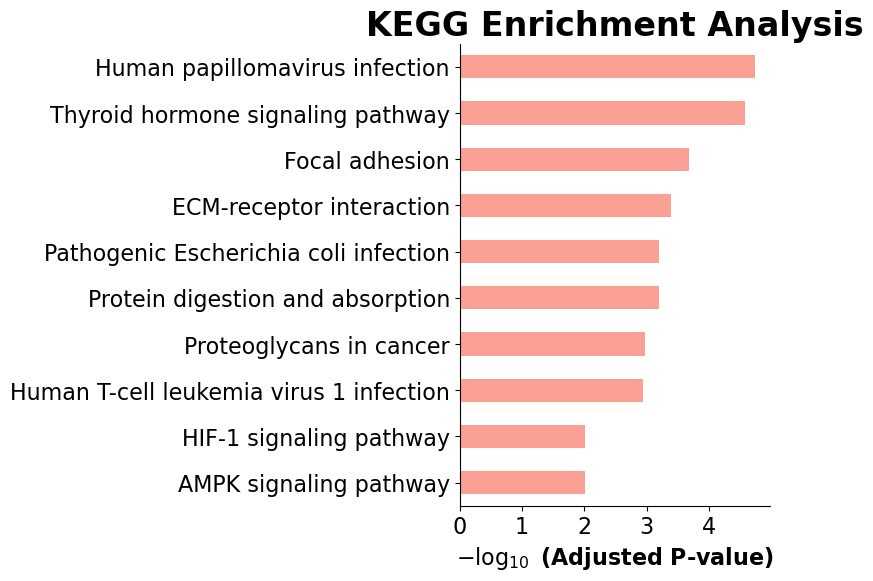

In [59]:
enr_spladder = gp.enrichr(gene_list=df_str_ase_spladder_filtered['gene_name'].tolist(), gene_sets='KEGG_2021_Human', outdir='enrich/enrichr_kegg_spladder')
gp.barplot(enr_spladder.res2d, title='KEGG Enrichment Analysis', top_term=10)
plt.show()

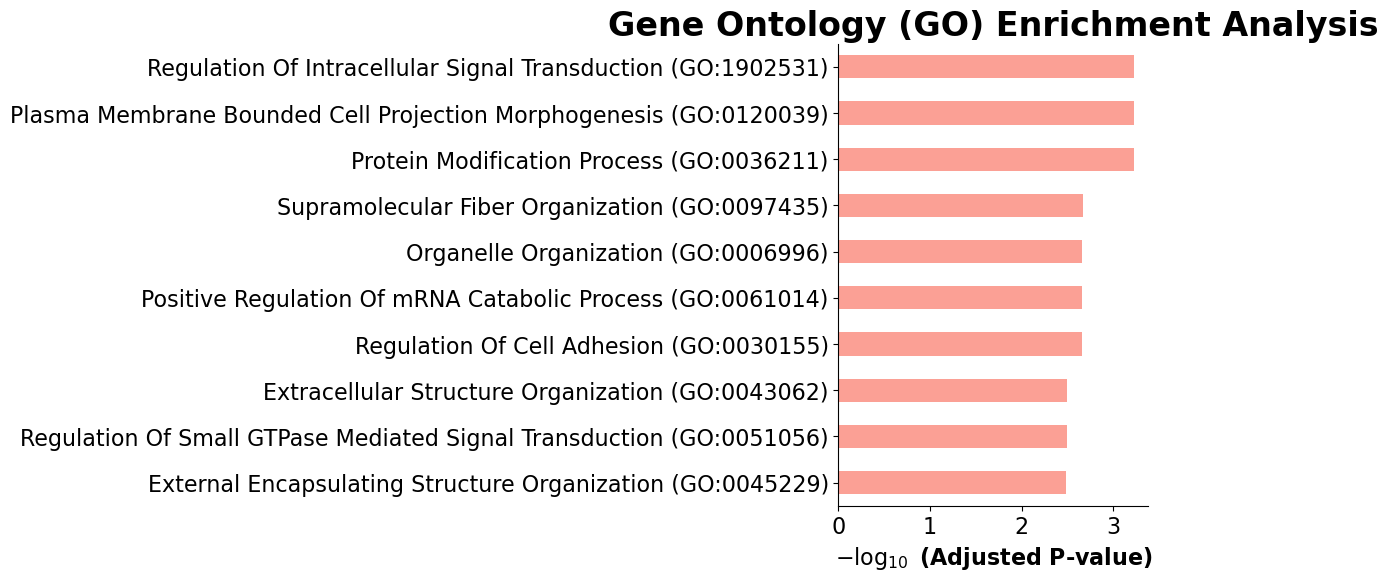

In [60]:
enr_spladder = gp.enrichr(gene_list=df_str_ase_spladder_filtered['gene_name'].tolist(), gene_sets='GO_Biological_Process_2023', outdir='enrich/enrichr_go_spladder')
gp.barplot(enr_spladder.res2d, title='Gene Ontology (GO) Enrichment Analysis', top_term=10)
plt.show()

### KEGG Pathway Enrichment Analysis SpliceSeq dataset 

In [238]:
# GO_Biological_Process_2023
enr_spliceseq = gp.enrichr(gene_list=df_str_ase_spliceseq_filtered['gene_names'].tolist(), gene_sets='KEGG_2021_Human', outdir='enrich/enrichr_kegg_spliceseq')
gp.barplot(enr_spliceseq.res2d, title='KEGG Enrichment Analysis', top_term=20)
plt.show()

ValueError: Warning: No enrich terms when cutoff = 0.05

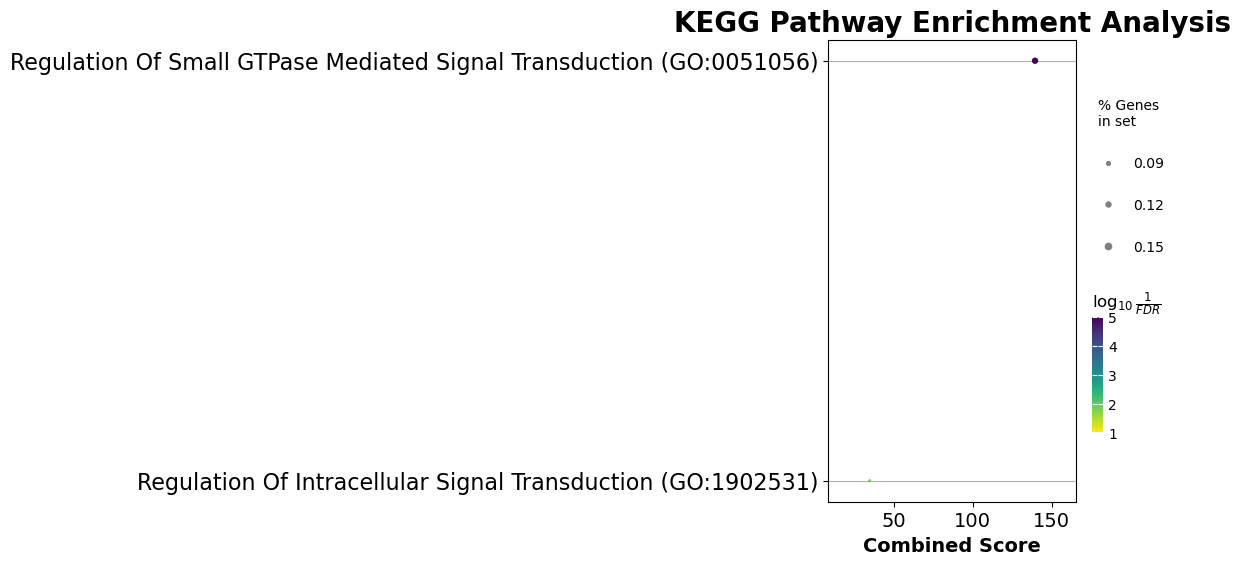

In [185]:
gp.dotplot(enr_spliceseq.res2d, title='KEGG Pathway Enrichment Analysis', top_term=10)
plt.show()

## Covariance 

In [162]:
crc_samples_meta_data_spladder = crc_samples_meta_data[crc_samples_meta_data['patient'].isin(cols_str_ase_spladder)]
#crc_samples_meta_data['gender'] = crc_samples_meta_data['gender'].map({'male': 0, 'female':1})
#crc_samples_meta_data['ad_race'] = crc_samples_meta_data['ad_race'].map({'NOT': 0, 'EUR':1, 'EAS':2, 'AFR': 3})
df_SplAdder_selected = df_SplAdder[crc_samples_meta_data_spladder['patient'].to_list()]
df_SplAdder_selected

,TCGA-DC-6158,TCGA-F4-6854,TCGA-DC-5337,TCGA-DM-A28F,TCGA-NH-A6GC,TCGA-A6-2675,TCGA-EI-6510,TCGA-G5-6641,TCGA-D5-6922,TCGA-EF-5830,...,TCGA-A6-2683,TCGA-AU-3779,TCGA-CM-6680,TCGA-AZ-6599,TCGA-AG-3742,TCGA-CM-6675,TCGA-AG-3725,TCGA-A6-2680,TCGA-G5-6233,TCGA-DM-A28G
0,NaN,1.000,NaN,1.000,1.000,1.000,NaN,NaN,0.966,NaN,...,1.000,1.000,1.000,1.000,NaN,1.000,NaN,0.934,NaN,1.000
1,NaN,0.019,NaN,0.027,0.000,0.026,NaN,NaN,0.014,NaN,...,0.006,0.023,0.013,0.039,NaN,0.017,NaN,0.023,NaN,0.018
2,NaN,1.000,NaN,1.000,1.000,1.000,NaN,NaN,1.000,NaN,...,0.959,1.000,1.000,1.000,NaN,1.000,NaN,1.000,NaN,1.000
3,NaN,1.000,NaN,1.000,1.000,1.000,NaN,NaN,1.000,NaN,...,1.000,1.000,1.000,1.000,NaN,1.000,NaN,1.000,NaN,1.000
4,NaN,1.000,NaN,1.000,1.000,1.000,NaN,NaN,1.000,NaN,...,1.000,1.000,1.000,1.000,NaN,1.000,NaN,1.000,NaN,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65458,NaN,0.548,NaN,0.596,0.562,0.540,NaN,NaN,0.500,NaN,...,0.575,0.527,0.567,0.629,NaN,0.518,NaN,0.673,NaN,0.600
65459,NaN,0.828,NaN,0.854,0.883,0.858,NaN,NaN,0.858,NaN,...,0.832,0.836,0.823,0.838,NaN,0.856,NaN,0.827,NaN,0.873
65464,NaN,0.472,NaN,0.583,NaN,0.546,NaN,NaN,0.547,NaN,...,0.487,0.471,0.519,0.388,NaN,0.456,NaN,0.613,NaN,0.505
65465,NaN,0.513,NaN,0.559,0.508,0.468,NaN,NaN,0.497,NaN,...,0.547,0.466,0.521,0.448,NaN,0.464,NaN,0.541,NaN,0.560


## ANOVA analysis

In [232]:
def anova_covariates(crc_meta_data, df_sig_selected, df_ase, df_source='SplAdder'):
    ase_influence_gender, ase_influence_race = [], []

    for i in range(len(df_sig_selected)):
        data = {
            'psi_values': df_sig_selected.iloc[i].fillna(0).to_list(),
            'gender': crc_meta_data['gender'],
            'race': crc_meta_data['ad_race']
        }
        data = pd.DataFrame(data)

        # Erstellen des linearen Modells
        model = ols('psi_values ~ C(gender) + C(race)', data=data).fit()

        # Durchführung der ANOVA-Analyse
        anova_table = sm.stats.anova_lm(model, typ=2)

        #print(anova_table)
        # ANSI-Escape-Sequenzen für fett und zurücksetzen
        bold = "\033[1m"
        reset = "\033[0m"

        # Interpretation der Ergebnisse
        if df_source == 'SplAdder':
            if anova_table['PR(>F)'][0] < 0.05:
                #print(f"Splice Event {bold}{df_SplAdder['SpliceEvent'].iloc[i]}{reset}: Gender has a significant influence on the PSI values.")
                ase_influence_gender.append(df_ase['SpliceEvent'].iloc[i])
            if anova_table['PR(>F)'][1] < 0.05:
                #print(f"Splice Event {bold}{df_SplAdder['SpliceEvent'].iloc[i]}{reset}: Race has a significant influence on the PSI values.")
                ase_influence_race.append(df_ase['SpliceEvent'].iloc[i])
        else:
            if anova_table['PR(>F)'][0] < 0.05:
                ase_influence_gender.append('id: ' + str(df_SpliceSeq['as-id'].iloc[i]) + ' type: ' + df_SpliceSeq['cancer-type'].iloc[i])
            if anova_table['PR(>F)'][1] < 0.05:
                ase_influence_race.append('id: ' + str(df_SpliceSeq['as-id'].iloc[i]) + ' type: ' + df_SpliceSeq['cancer-type'].iloc[i])    
        
    print(f"Number of splice events where {bold}gender{reset} has a significant influence on the PSI values: {len(ase_influence_gender)}." ,'\n',
        f"Number of splice events where {bold}race{reset} has a significant influence on the PSI values: {len(ase_influence_race)}")
    
    return ase_influence_gender, ase_influence_race

In [229]:
spladder_ase_influence_gender, spladder_ase_influence_race = anova_covariates(crc_samples_meta_data_spladder, df_SplAdder_selected, df_SplAdder)

Number of splice events where gender has a significant influence on the PSI values: 106. 
 Number of splice events where race has a significant influence on the PSI values: 34703


In [ ]:
crc_samples_meta_data_spliceseq= crc_samples_meta_data[crc_samples_meta_data['patient'].isin(cols_str_ase_spliceseq)]
df_SpliceSeq_selected = df_SpliceSeq[crc_samples_meta_data_spliceseq['patient'].to_list()]
df_SpliceSeq_selected

,TCGA-DC-6158,TCGA-F4-6854,TCGA-DC-5337,TCGA-AA-3561,TCGA-AA-A00O,TCGA-DM-A28F,TCGA-AA-3866,TCGA-AF-3913,TCGA-AA-3524,TCGA-AA-3877,...,TCGA-AG-3742,TCGA-CM-6675,TCGA-AA-3556,TCGA-AG-3725,TCGA-AG-3878,TCGA-AA-3818,TCGA-AG-A00C,TCGA-A6-2680,TCGA-G5-6233,TCGA-DM-A28G
0,NaN,0.9289,NaN,1.0000,1.0000,0.9115,NaN,NaN,1.0,0.8190,...,NaN,0.9847,NaN,NaN,NaN,0.9528,NaN,NaN,NaN,0.9258
1,NaN,0.9138,NaN,1.0000,1.0000,0.9287,1.0000,NaN,NaN,0.9742,...,NaN,0.9896,0.9652,NaN,NaN,0.9630,NaN,NaN,NaN,0.9564
2,NaN,0.5835,NaN,0.4638,0.4478,0.4743,0.2449,NaN,NaN,0.1201,...,NaN,0.4020,0.0475,NaN,NaN,0.4599,NaN,NaN,NaN,0.3916
3,NaN,0.0155,NaN,0.0000,0.0542,0.0248,0.0000,NaN,0.0,0.0000,...,NaN,0.0312,0.0000,NaN,NaN,0.0602,NaN,0.0,NaN,0.1098
4,NaN,0.9845,NaN,1.0000,0.9458,0.9752,1.0000,NaN,1.0,1.0000,...,NaN,0.9688,1.0000,NaN,NaN,0.9398,NaN,1.0,NaN,0.8902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70286,0.1400,NaN,0.0804,NaN,NaN,NaN,NaN,0.1511,NaN,NaN,...,0.0576,NaN,NaN,0.0337,0.0797,NaN,NaN,NaN,0.0000,NaN
70287,0.7605,NaN,0.7054,NaN,NaN,NaN,NaN,0.7096,NaN,NaN,...,0.7657,NaN,NaN,0.7218,0.4198,NaN,NaN,NaN,0.8144,NaN
70288,0.4232,NaN,0.3768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4325,NaN,NaN,0.3353,0.4109,NaN,NaN,NaN,0.2892,NaN
70289,0.9521,NaN,0.9639,NaN,NaN,NaN,NaN,0.9063,NaN,NaN,...,0.9592,NaN,NaN,0.9595,0.9132,NaN,0.9425,NaN,0.9681,NaN


In [233]:
spliceseq_ase_influence_gender, spliceseqr_ase_influence_race = anova_covariates(crc_samples_meta_data_spliceseq, df_SpliceSeq_selected ,df_SpliceSeq, df_source='SpliceSeq')

Number of splice events where gender has a significant influence on the PSI values: 3031. 
 Number of splice events where race has a significant influence on the PSI values: 48447


In [246]:
df_SpliceSeq['gene_names'].value_counts() # 9175 genes, 70291 ASE
df_SplAdder['gene_names'].value_counts() # 7206 genes, 41783 ASE

UBC         441
CDHR5       253
SEC14L1     149
RRBP1       136
AHNAK       103
           ... 
CCDC112       1
PANX1         1
FDX1          1
TMEM167A      1
MTHFSD        1
Name: gene_names, Length: 7206, dtype: int64

In [164]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

regression_results = pd.DataFrame(columns=['gene_name', 'cancer_typ', 'crc_str', 'as_id', 'r_squared', 'adj_r_squared', 'f_pvalue', 'durbin_watson', 'pvalues_str_len', 'pvalues_race' ])

for i in range(len(df_SpliceSeq)):
    # auswahl ist fehlerhaft -> muss aus den crc-ase pairs entnommen werden
    test_df = pd.DataFrame({'psi':df_SpliceSeq.iloc[:, 11:].iloc[i].to_list(),
                            'str_len': pivot_annotated.iloc[:, 3:].iloc[i].to_list(),
                            'race': crc_samples_meta_data_spliceseq['ad_race']})
    test_df = test_df.fillna(0)
    model = smf.ols('psi ~ str_len', data=test_df).fit()
    
    r_squared = model.rsquared
    adj_r_squared = model.rsquared_adj
    f_pvalue = model.f_pvalue
    pvalues = model.pvalues
    durbin_watson = sm.stats.stattools.durbin_watson(model.resid)

    #print(r_squared, adj_r_squared, f_pvalue, pvalues, durbin_watson)

    regression_results.append({
    'gene_name': df_SpliceSeq['gene_names'].iloc[i],
    'cancer_typ': df_SpliceSeq['cancer-type'].iloc[i],
    'crc_str': pivot_annotated['tmp_id'].iloc[i], 
    'as_id': str_ase_pairs['as-id'].iloc[i],
    'r_squared': r_squared,
    'adj_r_squared': adj_r_squared,
    'f_pvalue': f_pvalue,
    'durbin_watson': durbin_watson,
    'pvalues_str_len': pvalues['str_len'],
    'pvalues_race': pvalues.filter(like='C(race)').to_dict()
    }, ignore_index =True)
    if i % 1000 == 0:
        print(i)


0
1000


KeyboardInterrupt: 

In [158]:
pivot_annotated

,tmp_id,gene_names,gene_ensembl_ids,TCGA-A6-2678,TCGA-AA-A02F,TCGA-AA-3930,TCGA-AG-3882,TCGA-AY-A71X,TCGA-AZ-4323,TCGA-QG-A5Z1,...,TCGA-NH-A8F7,TCGA-AA-3867,TCGA-AA-3530,TCGA-A6-2674,TCGA-AA-A02J,TCGA-D5-5539,TCGA-DM-A1HB,TCGA-AZ-4616,TCGA-CM-6170,TCGA-G4-6628
0,chr10_100042463,CPN1,ENSG00000120054,0,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,chr10_100069930,CPN1,ENSG00000120054,0,10,10,9,10,0,0,...,10,10,10,10,10,10,10,0,9,9
2,chr10_1000869,GTPBP4,ENSG00000107937,0,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
3,chr10_100152407,ERLIN1,ENSG00000107566,0,4,4,4,4,4,0,...,4,4,4,0,4,4,4,0,4,4
4,chr10_100218932,CHUK,ENSG00000213341,0,17,17,17,17,17,0,...,17,0,0,17,17,17,17,0,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32524,chrX_97247622,DIAPH2,ENSG00000147202,0,9,0,9,9,9,0,...,9,9,9,9,9,9,8,9,9,9
32525,chrX_97247846,DIAPH2,ENSG00000147202,0,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
32526,chrX_97429811,DIAPH2,ENSG00000147202,0,12,0,11,11,0,0,...,12,0,0,11,12,11,10,0,11,0
32527,chrX_9760652,GPR143,ENSG00000101850,0,0,0,4,4,0,4,...,4,0,4,4,0,4,4,0,4,4
